# Lab1: Binary image classifier

## 1. Setup
Install fastbook and setup Google drive connection.

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Import necessary libraries

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

## 2. Download images 
Use Azure image search or DuckDuckGo to download 150 images of each class. Save images to Google drive.

### 2.1 Try it out
Similar to the lecture notebook, try out your query and plot a few of the resulting images to verify that your search returns sensible images.

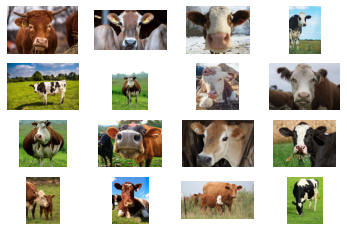

In [ ]:
import matplotlib.pyplot as plt

key = '08d0abf6632745a192947fc79bd399fb'
results = search_images_bing(key, 'cow')
cows = results.attrgot('thumbnailUrl')
results = search_images_bing(key, 'horse')
horses = results.attrgot('thumbnailUrl')

f, axes = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        image_data = requests.get(cows[i+4*j])
        image_data.raise_for_status()
        image = Image.open(BytesIO(image_data.content))        
        axes[i][j].imshow(image)
        axes[i][j].axis("off")
plt.show()

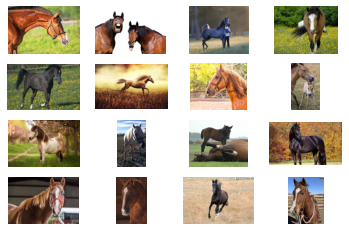

In [ ]:

f, axes = plt.subplots(4, 4)

for i in range(4):
    for j in range(4):
        image_data = requests.get(horses[i+4*j])
        image_data.raise_for_status()
        image = Image.open(BytesIO(image_data.content))        
        axes[i][j].imshow(image)
        axes[i][j].axis("off")
plt.show()

### 2.2 Get images for the two classes
Download 150 images of each class. Save images to Google drive.  
Remove any corrupt images using `verify_images()`.

In [ ]:
export_path= Path('/content/gdrive/MyDrive/ENSF_411/')
animal = 'cow', 'horse'
path = export_path/'animal'

if not path.exists():
    path.mkdir()
    for o in animal:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))


In [ ]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink);

## 3. Setup image loaders
Setup image loaders, use 20% of images for validation, and show one batch for each training and validation dataset.

In [ ]:
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #image->discrete category
    get_items=get_image_files, # path->images
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #how to train-valid split
    get_y=parent_label, # get the label from the directory name
    item_tfms=RandomResizedCrop(224, min_scale=0.5), # random crop at each iteration, resize to 224x224
    batch_tfms=aug_transforms()) #a set of transformations like  rotation, flipping, perspective warping, brightness changes and contrast changes

dls = animals.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


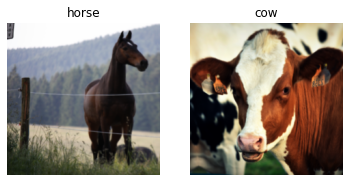

In [ ]:
dls.train.show_batch(max_n=2, nrows=1)

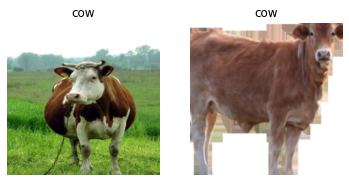

In [ ]:
dls.valid.show_batch(max_n=2, nrows=1)

**Question 1:** How many images of each class are in trainging and validation sets?

Training:232
Validation: 58

## 4. Setup cnn learner
Setup a cnn learner with the dataloaders, `resnet18` architecture and `error_rate` as metric.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## 5. Train binary classifier
Fine tune for 10 epochs and show results.

In [ ]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.032803,0.248382,0.051724,00:20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.008416,0.237519,0.086207,00:18
1,0.020471,0.240594,0.086207,00:18
2,0.016484,0.257954,0.068965,00:18
3,0.018856,0.301349,0.068965,00:18
4,0.035335,0.327104,0.086207,00:20
5,0.041238,0.364037,0.103448,00:18
6,0.041069,0.272954,0.103448,00:18
7,0.039990,0.235280,0.103448,00:18
8,0.037654,0.208439,0.086207,00:18
9,0.033739,0.205270,0.068965,00:18


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

**Question 2:** Is the model overfitting? Why, why not?

The error rate seems to get worse and this implies the model is overfitting


## 6. Analyze results

Plot confusion matrix.

Plot top 5 losses.


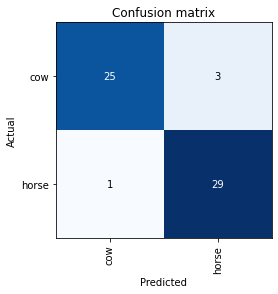

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

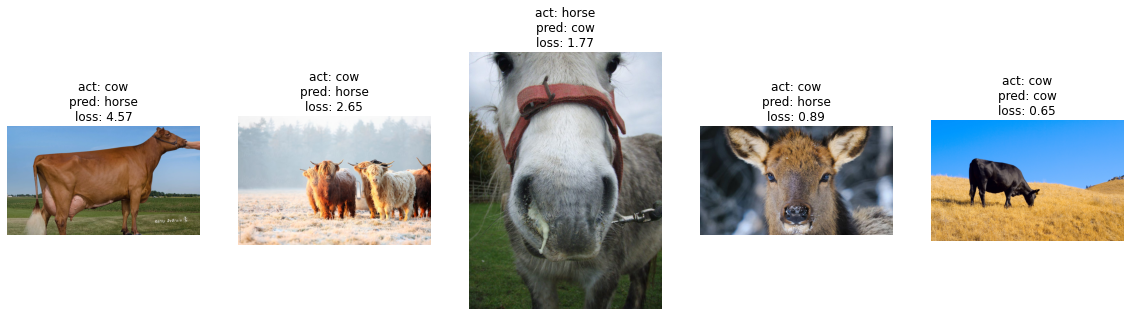

In [ ]:
k=5
losses, idxs = interp.top_losses(k)
predicteds = interp.preds[idxs].argmax(axis=1)
fig, axs = plt.subplots(nrows=1, ncols=k, figsize=(20, 10))

for ax, id, loss, pred in zip(axs, idxs, losses, predicteds):
    img, actual = dls.valid_ds[id]
    img.show(ctx=ax)
    ax.set_title(f'act: {dls.vocab[actual.item()]}\npred: {dls.vocab[pred]}\nloss: {loss:.2f}')

**Question 3:** How many false positive, false negative errors?

- False Positive: 3
- False Negative: 1

## 7. Summary and Conclusion

Summarize:
- Type of classifier trained.
- Number of images of each class in the training validation sets
- Error rate achieved

- Type: Binary
- Training: 232, Validation: 58

Conclusion:
- Are there any problems with data/labeling?
- Are you satisfied with model performance? Why, why not?

There is one for sure as can be seen in the top 5 losses. One of the photo's is clearly a deer and neither a cow or a horse. The model is overfitting however I am satisfied for now as there were very few erros in the end. 


## 8. Reflection
Include a sentence or two about 
- what you liked or disliked, 
- found interesting, confusing, challangeing, motivating 

while working on this assignment.

I enjoyed being able to choose my own data because I am more vested in the assignment and I was continuously thinking about actual applications of the code! Overall good intro!
